# 4.2 Physics-Informed Neural Networks

In the physical sciences, we may already have physical models to explain observations. The fundamental principle in PINNs trains a neural network that is physis-agnostic at initial design, but constraining the predictions to obey physical law by crafting the loss function accordingly.

We will take the simple example of the heat diffusion in 1D. The tutorial below is inspired by https://github.com/TheodoreWolf/pinns.

In [20]:
import functools
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.manual_seed(42)
np.random.seed(10)

The heat equation is a diffusion equation:

$\frac{\partial T}{\partial t} (x,t) = k \frac{\partial^2 T}{\partial x^2} (x,t)$,

where $k$ is the diffusivity. 


First, we create synthetic, toy, noisy data.

In [43]:
def cooling_law(time, Tenv, T0, tau):
    # T = Tenv + (T0 - Tenv) * scipy.special.erf(time/k)
    T = Tenv + (T0 - Tenv) * (1 - np.exp(-time/tau))
    return T

Make noisy synthetic data

Text(0.5, 0, 'Time (s)')

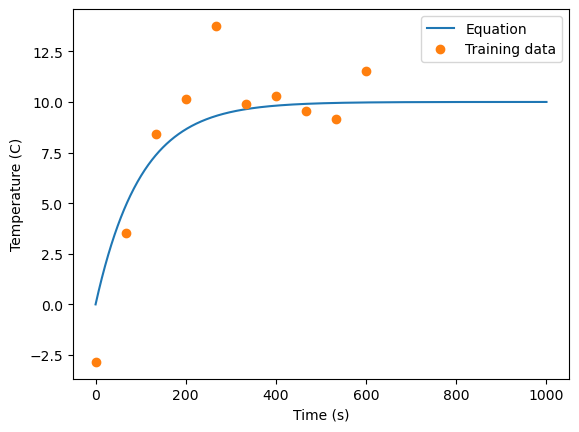

In [56]:
Tenv = 0
T0 = 10
tau = 100
times = np.linspace(0, 1000, 1000)
eq = functools.partial(cooling_law, Tenv=Tenv, T0=T0, tau=tau )
temps = eq(times)

# Make training data
t = np.linspace(0, 600, 10)
T = eq(t) +  2 * np.random.randn(10)

plt.plot(times, temps)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

Create a simple neural network

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as thdat



def np_to_th(x): # Convert numpy array to torch tensor
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).to(DEVICE).reshape(n_samples, -1)


def grad(outputs, inputs): # Compute gradient of outputs with respect to inputs
    """Computes the partial derivative of 
    an output with respect to an input.
    Args:
        outputs: (N, 1) tensor
        inputs: (N, D) tensor
    """
    return torch.autograd.grad(
        outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True
    )

class NNet(nn.Module): # a class defines an object

    # this defines the architecture of the NN
    def __init__(self, input_dim=1, output_dim=1,n_units=100): 
        # Here we define all the functions that we will use during the forward part (data -> prediction)
        super(NNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
            nn.Linear(n_units, n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(n_units, output_dim)
    # this defines how the data passes through the layers
    def forward(self, x):
        # Here we explain in which order to use the functions defined above
        return self.out(self.layers(x))





class Net(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=1e-3,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)

        return out

    def fit(self, X, y):
        Xt = np_to_th(X)
        yt = np_to_th(y)

        optimiser = optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []
        for ep in range(self.epochs):
            optimiser.zero_grad()
            outputs = self.forward(Xt)
            loss = self.loss(yt, outputs)
            if self.loss2:
                loss += self.loss2_weight + self.loss2_weight * self.loss2(self)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            if ep % int(self.epochs / 10) == 0:
                print(f"Epoch {ep}/{self.epochs}, loss: {losses[-1]:.2f}")
        return losses

    def predict(self, X):
        self.eval()
        out = self.forward(np_to_th(X))
        return out.detach().cpu().numpy()


In [ ]:
net2

In [76]:
net = NNet(1,1,100).to(DEVICE)
net.eval()

NNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=100, bias=True)
    (7): ReLU()
  )
  (out): Linear(in_features=100, out_features=1, bias=True)
)

In [102]:
def train(model, X, Y,
        lr=1e-3,
        loss2=None,
        epochs=1000,
        loss2_weight=0.1 ):
    # Convert numpy arrays to torch tensors
    Xt = np_to_th(X)
    yt = np_to_th(Y)

    # Define loss and optimization method
    optimizer = optim.SGD(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    # model.train()
    losses = []
    # # Loop on number of epochs
    for ep in range(epochs):
        optimizer.zero_grad()
        outputs = model.forward(Xt)
        loss = criterion( yt,outputs)
        print(outputs,yt)
        print(loss)
        if loss2:
            loss += loss2_weight + loss2_weight * loss2(model)
        loss.backward() # Propagate the loss backward
        optimizer.step() # Update the gradients
        losses.append(loss.item())
        if ep % int(epochs / 10) == 0:
            print(f"Epoch {ep}/{epochs}, loss: {losses[-1]:.2f}")

    return losses

(10,)
(10,)
tensor([[0.0300],
        [0.6941],
        [1.3585],
        [2.0233],
        [2.6880],
        [3.3528],
        [4.0175],
        [4.6823],
        [5.3470],
        [6.0118]], grad_fn=<AddmmBackward0>) tensor([[-2.8418],
        [ 3.5079],
        [ 8.4318],
        [10.1346],
        [13.7553],
        [ 9.8776],
        [10.3061],
        [ 9.5514],
        [ 9.1403],
        [11.5388]])
tensor(40.5238, grad_fn=<MseLossBackward0>)
Epoch 0/1000, loss: 40.52
tensor([[8.1459e-01],
        [1.1559e+02],
        [2.3128e+02],
        [3.4696e+02],
        [4.6265e+02],
        [5.7834e+02],
        [6.9402e+02],
        [8.0971e+02],
        [9.2540e+02],
        [1.0411e+03]], grad_fn=<AddmmBackward0>) tensor([[-2.8418],
        [ 3.5079],
        [ 8.4318],
        [10.1346],
        [13.7553],
        [ 9.8776],
        [10.3061],
        [ 9.5514],
        [ 9.1403],
        [11.5388]])
tensor(370754.4062, grad_fn=<MseLossBackward0>)
tensor([[-2.9358e+06],
        [-1

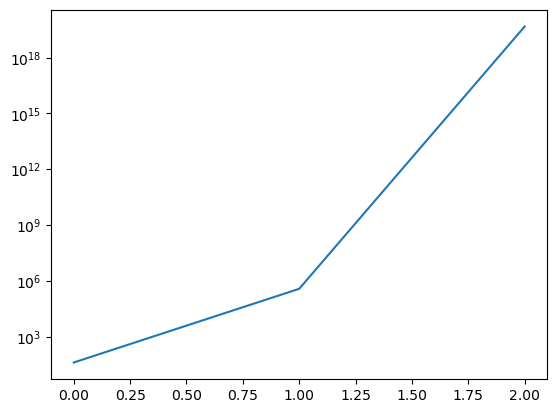

In [103]:
# net2 = Net(1,1, loss2=None, epochs=20000, lr=1e-5).to(DEVICE)
# losses = net2.fit(t,T)



net = NNet(1,1,100).to(DEVICE)

print(t.shape)
print(T.shape)
losses = train(net, t,T)

plt.plot(losses)
plt.yscale('log')

In [13]:
# define the second loss function as the L2 norm of the weights
def l2_reg(model: torch.nn.Module):
    return torch.sum(sum([p.pow(2.) for p in model.parameters()]))

Epoch 0/20000, loss: 12292.20
Epoch 2000/20000, loss: 4400.56
Epoch 4000/20000, loss: 2655.44
Epoch 6000/20000, loss: 1644.61
Epoch 8000/20000, loss: 1145.21
Epoch 10000/20000, loss: 926.02
Epoch 12000/20000, loss: 859.71
Epoch 14000/20000, loss: 719.42
Epoch 16000/20000, loss: 638.16
Epoch 18000/20000, loss: 566.01


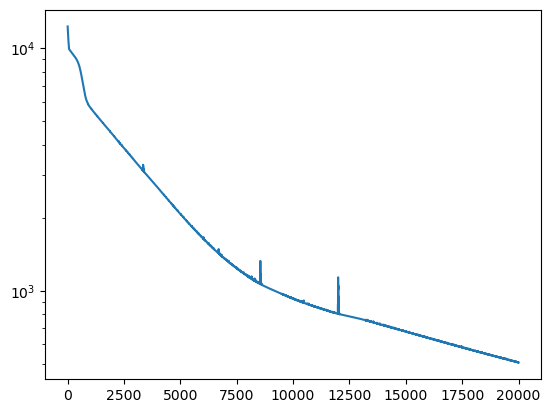

In [14]:
netreg = Net(1,1, loss2=l2_reg, epochs=20000, lr=1e-4, loss2_weight=1).to(DEVICE)

losses = netreg.fit(t, T)

plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

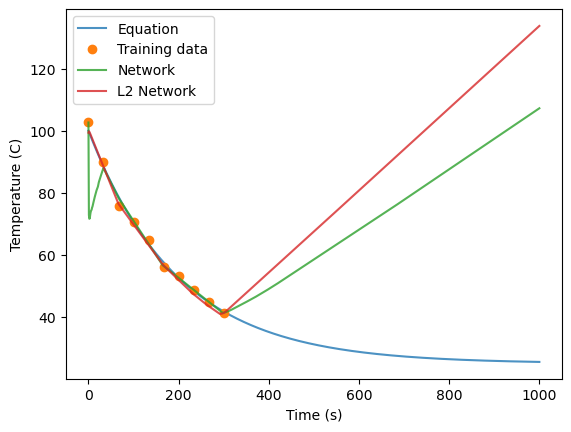

In [15]:
predsreg = netreg.predict(times)

preds = net.predict(times)
plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.plot(times, predsreg, alpha=0.8)

plt.legend(labels=['Equation','Training data', 'Network', 'L2 Network'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

## PINN

In [16]:
def physics_loss(model: torch.nn.Module):
    ts = torch.linspace(0, 1000, steps=1000,).view(-1,1).requires_grad_(True).to(DEVICE)
    temps = model(ts)
    dT = grad(temps, ts)[0]
    pde = R*(Tenv - temps) - dT
    
    return torch.mean(pde**2)

Epoch 0/30000, loss: 4817.04
Epoch 3000/30000, loss: 2393.49
Epoch 6000/30000, loss: 464.83
Epoch 9000/30000, loss: 2.43
Epoch 12000/30000, loss: 1.89
Epoch 15000/30000, loss: 1.65
Epoch 18000/30000, loss: 1.41
Epoch 21000/30000, loss: 1.20
Epoch 24000/30000, loss: 1.11
Epoch 27000/30000, loss: 1.07


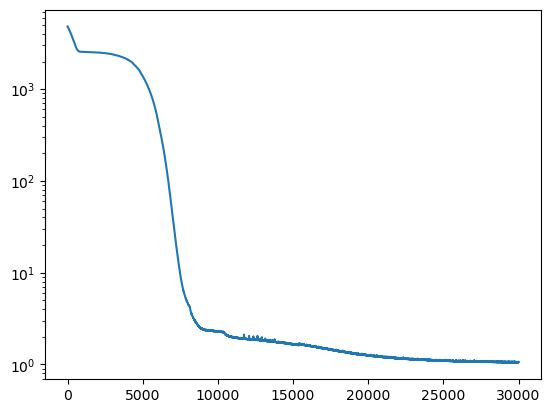

In [17]:
net = Net(1,1, loss2=physics_loss, epochs=30000, loss2_weight=1, lr=1e-5).to(DEVICE)

losses = net.fit(t, T)
plt.plot(losses)
plt.yscale('log')


Text(0.5, 0, 'Time (s)')

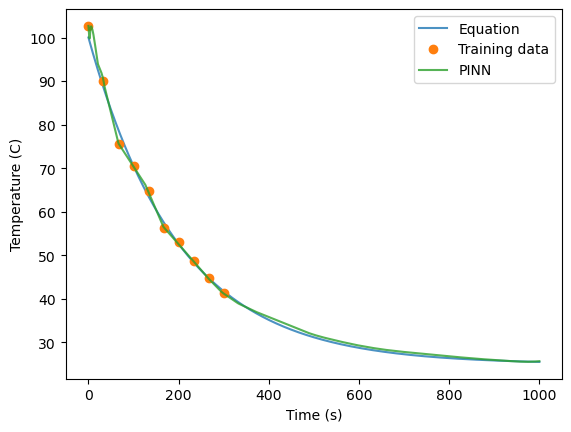

In [18]:
preds = net.predict(times)

plt.plot(times, temps, alpha=0.8)
plt.plot(t, T, 'o')
plt.plot(times, preds, alpha=0.8)
plt.legend(labels=['Equation','Training data', 'PINN'])
plt.ylabel('Temperature (C)')
plt.xlabel('Time (s)')

In [ ]:

class NetDiscovery(Net):
    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(
            input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight
        )

        self.r = nn.Parameter(data=torch.tensor([0.]))